# An example of using multi-imbalance
Now we will demonstrate how to solve a multi-class imbalanced task by using our library.
We choose well known glass data coming from UCI ML repository.
It contains information about the purpose of glass, e.g. for windows or headlights in cars with are
categorized in several classes where we identify four classes are minority ones. The previous research
has shown that glass is a difficult dataset.

We will predict the class based on 214 examples with 9 attributes representing the content of individual
elements such as Aluminum or Magnesium in the tested sample.

In [13]:
import os
import numpy as np

seed = 12
np.random.seed(seed)

%matplotlib inline

dataset_name = 'glass'
dir = os.getcwd()

### Data loading

We begin with loading the dataset, which is stored in popular within the imbalanced data 
community arff file.  A file in arff format can contain both numerical and nominal attributes 
that need to be converted into numerical ones for compatibility with sklearn. 
The multi-imbalance util loads the arff file seamlessly, automatically performing one-hot 
encoding for discrete features. All continuous features are put into the data frame first, 
followed by the ones modified by one-hot encoder.

In [14]:
from multi_imbalance.utils.data import load_arff_dataset

X, y = load_arff_dataset(f'{dir}/../data/arff/{dataset_name}.arff')

print(X[:5])
print(y[:5])

[[ 1.51793 12.79     3.5      1.12    73.03     0.64     8.77     0.
   0.     ]
 [ 1.51643 12.16     3.52     1.35    72.89     0.57     8.53     0.
   0.     ]
 [ 1.51793 13.21     3.48     1.41    72.64     0.59     8.43     0.
   0.     ]
 [ 1.51299 14.4      1.74     1.54    74.55     0.       7.59     0.
   0.     ]
 [ 1.53393 12.3      0.       1.      70.16     0.12    16.19     0.
   0.24   ]]
[0 5 0 4 1]


This multi-class dataset is characterized by notable class imbalance
In order to better illustrate the imbalanced characteristics of this problem and difficulties of example
distribution in the attribute space, we visualize it with the function from multi-imbalance library,
which shows the class sizes and the data in a reduced two-dimensional space.

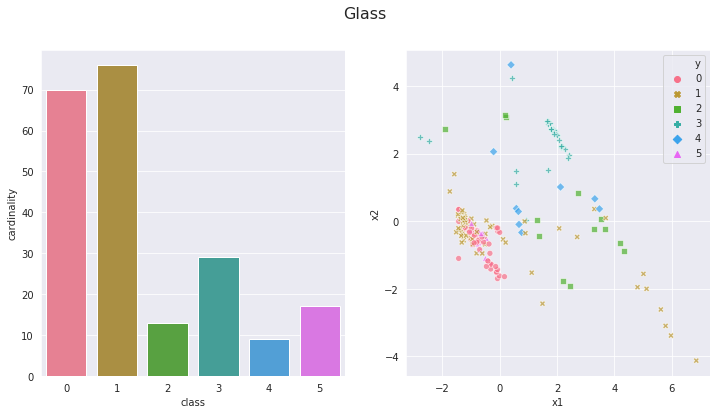

In [15]:
from multi_imbalance.utils.plot import plot_cardinality_and_2d_data
plot_cardinality_and_2d_data(X, y, 'Glass')

As shown above, there is multi-class imbalance in the dataset.
There are 2 majority classes and 4 minority classes.

### Data preparation

In order to prepare data for training, we will split the data for train and test
subsets and normalize it. For both operations, we will use tools available in sklearn.

In [16]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.35, stratify=y, random_state=seed)

scaler = StandardScaler()
scaler.fit(X_train)

X_train = scaler.transform(X_train)
X_test = scaler.transform(X_test)

### Training

The training will be performed using a decision tree implementation from sklearn library.
Our library integrates seamlessly with other popular libraries, which enables the use of all the benefits of the
Python ecosystem.

In [17]:
from sklearn.tree import DecisionTreeClassifier

clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

To evaluate predictions to multi-imbalanced class we apply generalized G-mean of sensitives of each class:
$$ gmean = (\Pi_{i=1}^n sensitivity_i)^{\frac{1}{n}}$$

In [18]:
from multi_imbalance.utils.metrics import gmean_score

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree: {round(gmean,3)}'

'Decision Tree: 0.222'

As one can see, the decision tree does not perform well for this type of problem.

### Resampling
MDO (Mahalanobis Distance Oversampling) and SOUP (Similarity Oversampling Undersampling Preprocessing) are 
are chosen to run as respresentative of more advanced preprocessing methods. As a first preprocessing we use MDO,
which generates synthetic samples which
have the same Mahalanobis distance from the considered class mean as other minority class examples.


In [19]:
from multi_imbalance.resampling.mdo import MDO

mdo = MDO(k1_frac=.3, maj_int_min={
        'maj': [0, 1],
        'min': [2, 3, 4, 5]
    })
X_train_res, y_train_res = mdo.fit_transform(X_train, y_train)


We will check how the cardinalities have changed using the function in our drawing util.

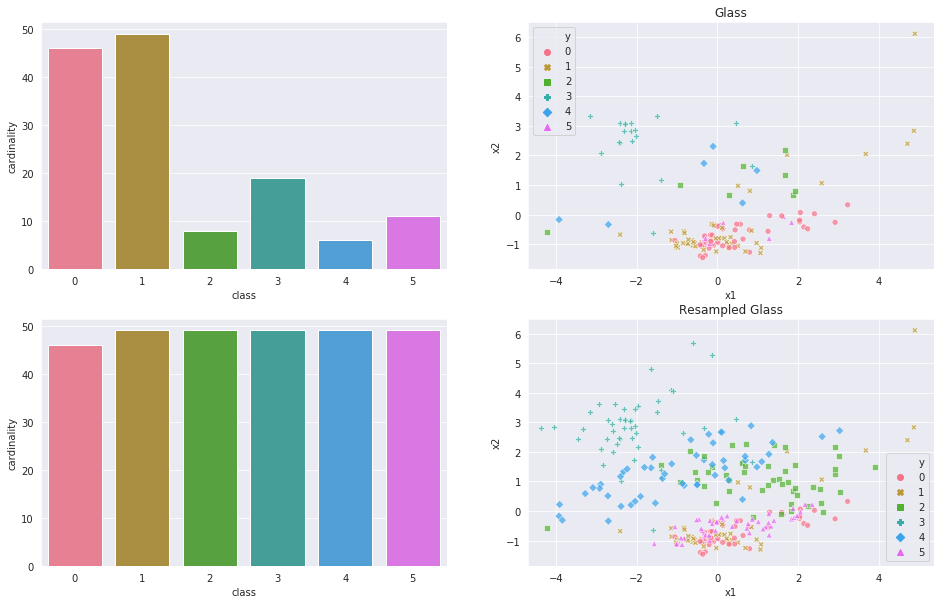

In [20]:
from multi_imbalance.utils.plot import plot_visual_comparision_datasets
plot_visual_comparision_datasets(X_train, y_train, X_train_res, y_train_res, 'Glass', 'Resampled Glass')

The minority classes have been oversampled. 

In [21]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + MDO: {round(gmean,3)}'


'Decision Tree + MDO: 0.626'

SOUP is a recently proposed hybrid data preprocessing method. It also handles complex inter-relations
between classes by means of their similarities and levels of difficulties
coefficients for examples belonging to each class.

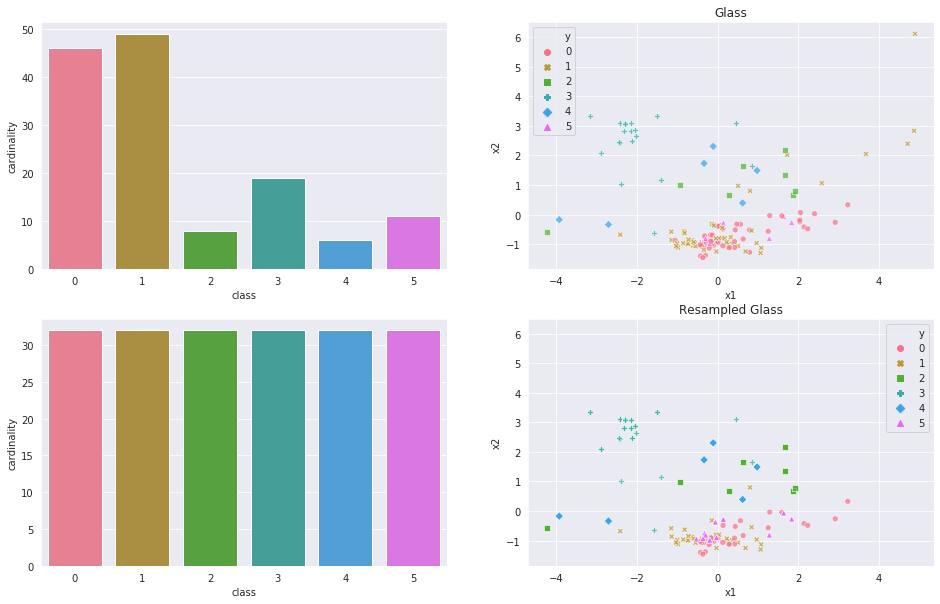

In [22]:
from multi_imbalance.resampling.soup import SOUP

soup = SOUP(maj_int_min={
        'maj': [0, 1],
        'min': [2, 3, 4, 5]
    })
X_train_res, y_train_res = soup.fit_transform(X_train, y_train)
plot_visual_comparision_datasets(X_train, y_train, X_train_res, y_train_res, 'Glass', 'Resampled Glass')

Class cardinalities have been equalized. Now, we perform the calculations once again with modified data.

In [23]:
clf = DecisionTreeClassifier(random_state=seed)
clf.fit(X_train_res, y_train_res)
y_pred = clf.predict(X_test)

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'Decision Tree + SOUP: {round(gmean,3)}'

'Decision Tree + SOUP: 0.743'

As one can notice, these specialized preprocessing methods improved G-mean evaluation measure.
As in the library there is also another category of method, i.e. ensembles,
let us illustrate how could work on this methods.

### Ensemble
In this case, OVO (one class versus one class) implementation will be used. OVO is a data decomposition method,
where classes are paired in all possible configurations and the pairs are used to train binary classifiers,
which votes are aggregated into the final decision. OVO implementation in our libray allows the use of any
type of classifier with an interface compatible with sklearn convention. The same applies to resampling methods.
Resampling is applied to pairs decomposed from the original data.
In this use case, SOUP will be used for resampling.

In [24]:
from multi_imbalance.ensemble.ovo import OVO

soup = SOUP(maj_int_min={
        'maj': [0, 1],
        'min': [2, 3, 4, 5]
    })

clf = OVO(
    binary_classifier=DecisionTreeClassifier(random_state=seed),
    preprocessing=soup
)

clf.fit(X_train, y_train)
y_pred = clf.predict(X_test)

gmean = gmean_score(y_test, y_pred, correction=0.001)
f'OVO with DecisionTree and SOUP: {round(gmean,3)}'

'OVO with DecisionTree and SOUP: 0.773'

As shown above, the OVO ensemble method along with SOUP resampling further improves the performance of the
decision tree.

### Conclusions
In this guide, we have shown that thanks to our library we can easily use methods dedicated to multi class imbalance
problems in real life datasets. During the entire tutorial,
we seamlessly integrated with popular libraries like sklearn and worked using well-known types like numpy arrays.
You can find more examples and descriptions of all methods in the documentation:
https://multi-imbalance.readthedocs.io/en/latest/
The source code is developed and available on Github at
https://github.com/damian-horna/multi-imbalance
More information about the library can be found at http://www.cs.put.poznan.pl/mlango/publications/multiimbalance
